## Describe corpus and create figures

This notebook was used to create the plots and figures used in the thesis

In [1]:
from pyspark import SparkContext
from os.path import basename, exists, isfile, isdir, sep
from os import makedirs, listdir, getcwd
from json import load, loads, dump
from datetime import datetime
from glob import glob
import pandas as pd

In [2]:
sc = SparkContext(master = 'local[8]')
path = "/home/jovyan/mnt/ceph/storage/data-in-progress/data-teaching/theses/wstud-thesis-sauer/thesis-sauer/final_corpus/undupe_authors"
if isdir(path):
    filepaths = sorted(glob(path + sep + "*"))

All authors are extracted from the corpus via Spark

In [3]:
print(datetime.now())
authors = []
for p in filepaths:
    print(basename(p))
    rdd = sc.textFile(f"file://{p}")
    data = rdd.map(lambda line: loads(line)['authors'])
    authors = authors + data.collect()
    print(datetime.now())

2021-06-24 18:03:58.361586
00
2021-06-24 18:05:02.943502
01
2021-06-24 18:06:16.720614
02
2021-06-24 18:07:09.703418
03
2021-06-24 18:08:55.185067
04
2021-06-24 18:09:48.615422
05
2021-06-24 18:10:41.105106
06
2021-06-24 18:10:59.540215
07
2021-06-24 18:11:17.942044
08
2021-06-24 18:11:35.694395
09
2021-06-24 18:11:54.004992
10
2021-06-24 18:12:11.704797
11
2021-06-24 18:12:29.319182
12
2021-06-24 18:12:48.090748
13
2021-06-24 18:13:06.181430
14
2021-06-24 18:13:56.712023
15
2021-06-24 18:14:58.810844
16
2021-06-24 18:15:59.651437
17
2021-06-24 18:17:02.203177
18
2021-06-24 18:18:05.977058
19
2021-06-24 18:18:51.563355
20
2021-06-24 18:19:45.505702
21
2021-06-24 18:20:58.762722
22
2021-06-24 18:22:04.383957
23
2021-06-24 18:22:32.295706
24
2021-06-24 18:23:02.295165
25
2021-06-24 18:23:33.465149
26
2021-06-24 18:24:05.963131
27
2021-06-24 18:24:39.212308
28
2021-06-24 18:25:13.676307
29
2021-06-24 18:26:04.678759
30
2021-06-24 18:27:24.440149
31
2021-06-24 18:28:16.983589
32
2021-06-24

In [4]:
len(authors)

3356745

Authorlists are divided in monographies and multiauthor documents

In [5]:
monographies = list(filter(lambda entry: len(entry) == 1, authors))
len(monographies)

973128

In [6]:
multiauthors = list(filter(lambda entry: len(entry) > 1, authors))
len(multiauthors)

2376082

A series containing the number of authors for all documents is created

In [7]:
number_of_authors = [len(x) for x in multiauthors]
pd.Series(number_of_authors).value_counts()

2       597908
3       499820
4       363353
5       254991
6       186358
         ...  
776          1
2820         1
2199         1
770          1
2030         1
Length: 1090, dtype: int64

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

Versions of countplots are created to visualize the counts of the number of authors per document. A version with all numbers and a version with an accumulated bar for all numbers higher than 100 for better readability is created

<AxesSubplot:title={'center':'Counts of authors per multiauthor-document'}, xlabel='Number of authors per multiauthor document', ylabel='Count of documents'>

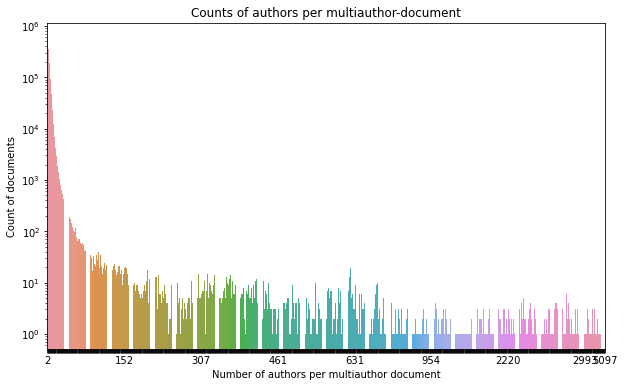

In [ ]:
plt.figure(figsize=(10, 6))
plot = sns.countplot(data=pd.DataFrame(number_of_authors,columns=["n_o_a"]),x='n_o_a')
plot.set(yscale='log',xlabel='Number of authors per multiauthor document', ylabel='Count of documents',title='Counts of authors per multiauthor-document')
l = len(plot.xaxis.get_ticklabels())
for i,label in enumerate(plot.xaxis.get_ticklabels()[:-1]):
    if i%150==0 and i<l-5:
        continue
    else:
        label.set_visible(False)
plot

<AxesSubplot:title={'center':'Count of documents by number of authors, documents with more than 100 authors grouped'}, xlabel='Number of authors per multiauthor document', ylabel='Count of documents'>

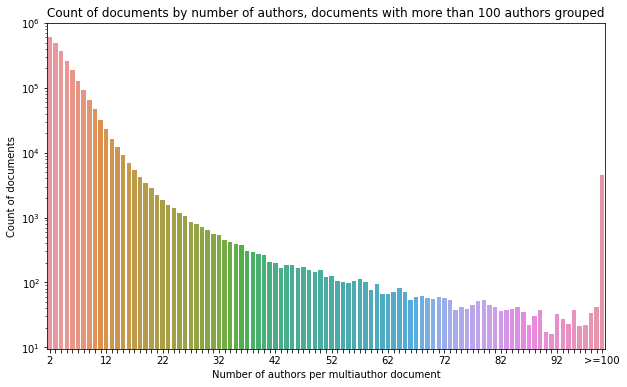

In [ ]:
def noa_classes(x):
    if x < 100:
        return x
    else:
        return '>=100'
plotdata = pd.DataFrame(map(noa_classes,number_of_authors),columns=["n_o_a"])
plt.figure(figsize=(10, 6))
plot = sns.countplot(data=plotdata,x='n_o_a',order=list(range(100))[2:]+['>=100'])
plot.set(yscale='log',xlabel='Number of authors per multiauthor document', ylabel='Count of documents',title='Count of documents by number of authors, documents with more than 100 authors grouped')
l = len(plot.xaxis.get_ticklabels())
for i,label in enumerate(plot.xaxis.get_ticklabels()[:-1]):
    if i%10==0:
        continue
    else:
        label.set_visible(False)
plot

Now we start to create a dataframe containing the number of monographies and multiauthor-documents for every author. It will also include a list of the positions the author has in the authorlists of his multiauthor-documents.

In [42]:
ids = pd.Series([x[0]['id'] for x in monographies])
author_idset = set(ids)

id_to_author = {}
for entry in monographies:
    if entry[0]['id'] in id_to_author:
        continue
    else:
        id_to_author[entry[0]['id']] = entry[0]['name']

In [43]:
singleauthor_counts = ids.value_counts()

In [44]:
print(f'Number of monography-authors in corpus: {len(singleauthor_counts)}')

Number of monography-authors in corpus: 795975


In [45]:
author_table = {}
for i in singleauthor_counts.index:
    author_table[i] = (id_to_author[i],int(singleauthor_counts[i]))

In [46]:
no_single = 0
no_multi = 0
multis_output = {}
for entry in multiauthors:
    omit = []
    hit = False
    for i,author in enumerate(entry):
        if author['id'] in author_idset and not author['id'] in omit:
            hit = True
            if author['id'] in multis_output:
                multis_output[author['id']] = (id_to_author[author['id']], multis_output[author['id']][1] + 1, multis_output[author['id']][2]+[i+1])
            else:
                multis_output[author['id']] = (id_to_author[author['id']], 1, [i+1])
            omit.append(author['id'])
    if not hit:
        no_single += 1
        
for i in author_table:
    if i in multis_output:
        author_table[i] = (author_table[i][0],author_table[i][1],multis_output[i][1],multis_output[i][2])
    else:
        author_table[i] = (author_table[i][0],author_table[i][1],0,[])
        no_multi += 1

print(f"Documents with no matching monograph: {no_single}")
print(f"Authors with monographs only: {no_multi}")

Documents with no matching monograph: 1481108
Authors with monographs only: 670577


In [48]:
df = pd.DataFrame.from_dict(author_table,orient='index',columns=['name','mono_docs','multi_docs','positions'])
df['avg_position'] = [round((sum(lst) / len(lst)),1) if lst else 0 for lst in df['positions']]
df.to_json("results/merge/single_multiauthors_dict.json")

In [9]:
df = pd.read_json("results/merge/single_multiauthors_dict.json")

In [50]:
df

,name,mono_docs,multi_docs,positions,avg_position
2648023147,Charlie Beckett,602,7,"[1, 1, 1, 2, 5, 1, 2]",1.9
217383518,Csusb,577,0,[],0.0
2561382056,Nigel Williams,391,0,[],0.0
2137451758,Steven Alan Samson,281,0,[],0.0
2098661866,Daily Egyptian Staff,246,0,[],0.0
...,...,...,...,...,...
2318434287,Afaf M. Abd El-Hameed,1,2,"[2, 3]",2.5
2155931765,C. A. Gagliardi,1,86,"[86, 92, 73, 88, 84, 72, 88, 309, 79, 99, 68, ...",87.2
2168795134,Andreas Heinemann,1,0,[],0.0
2327366664,Tanja Veikkola,1,0,[],0.0


Now we look at the positions in more detail

In [37]:
positions = df['positions'].explode()


In [38]:
positions = positions.dropna()
positions.value_counts()

2       328879
1       311487
3       191761
4       111614
5        72567
         ...  
3447         1
3481         1
3485         1
3486         1
5083         1
Name: positions, Length: 3196, dtype: int64

In [39]:
p = positions.value_counts()
print(f'Authorpositions highest of 5: {sum(p[p.index <= 5])}, highest of 10: {sum(p[p.index <= 10])}, of more than 10: {sum(p[p.index > 10])}')

Authorpositions highest of 5: 1016308, highest of 10: 1170511, of more than 10: 272494


We group positions and create a number of countplots

In [40]:
def group_positions(pos):
    if pos <= 10:
        return str(pos)
    elif pos <= 100:
        return "11-100"
    elif pos <= 1000:
        return "101-1000"
    else:
        return ">1000"

In [41]:
positions = pd.DataFrame(positions)


<AxesSubplot:title={'center':'Counts of positions of monograph-authors in multiauthor-lists (positions higher than 10 grouped)'}, xlabel='Position of monograph-author in authorlist', ylabel='Count of occurrence'>

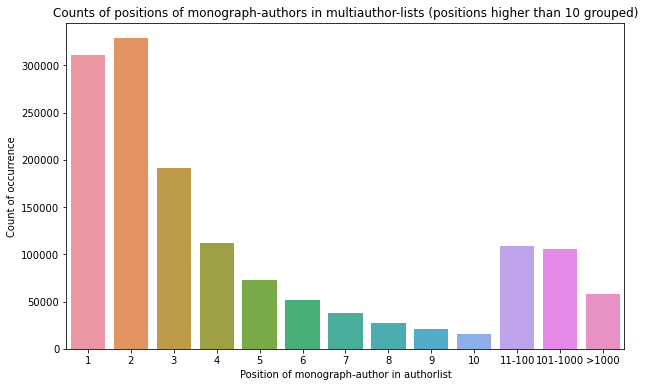

In [42]:
positions['group'] = [group_positions(x) for x in positions['positions']]

plt.figure(figsize=(10, 6))
plot = sns.countplot(data=positions,x='group',order=['1','2','3','4','5','6','7','8','9','10','11-100','101-1000','>1000'])
plot.set(xlabel='Position of monograph-author in authorlist', ylabel='Count of occurrence',title='Counts of positions of monograph-authors in multiauthor-lists (positions higher than 10 grouped)')
plot

In [43]:
positions

,positions,group
2648023147,1,1
2648023147,1,1
2648023147,1,1
2648023147,2,2
2648023147,5,5
...,...,...
2155931765,93,11-100
2155931765,7,7
2155931765,93,11-100
2155931765,91,11-100


<AxesSubplot:title={'center':'Frequency of positions of monograph-authors in multiauthor-lists'}, xlabel='Position of monograph-author in authorlist', ylabel='Frequency of occurrence'>

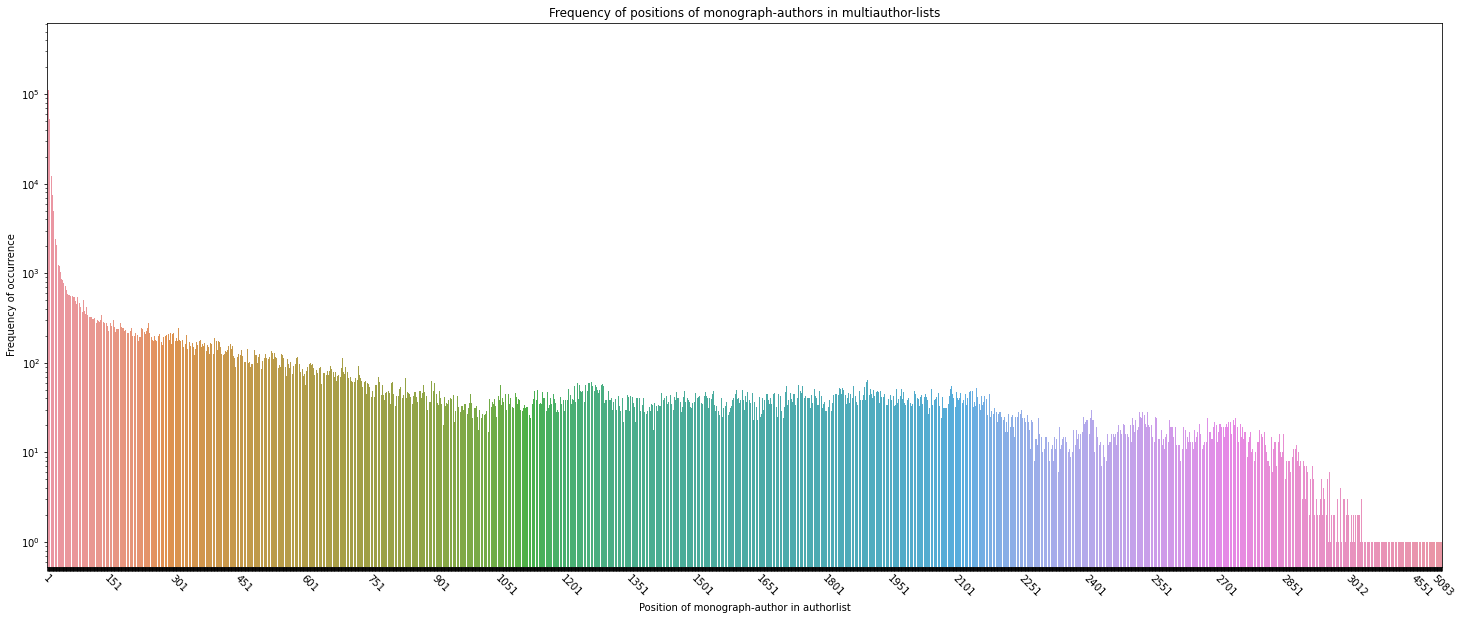

In [57]:
plt.figure(figsize=(25, 10))
plt.xticks(rotation=-45)
plot = sns.countplot(data=positions,x='positions')
plot.set(yscale='log',xlabel='Position of monograph-author in authorlist', ylabel='Frequency of occurrence',title='Frequency of positions of monograph-authors in multiauthor-lists')
l = len(plot.xaxis.get_ticklabels())
for i,label in enumerate(plot.xaxis.get_ticklabels()[:-1]):
    if i%150==0 and i<l-5:
        continue
    else:
        label.set_visible(False)
plot

In [48]:
pos_freq = positions['positions'].value_counts()
ser = pd.Series(data=[0 for i in range(max(pos_freq.index)+1)[1:]], index=range(max(pos_freq.index)+1)[1:])
pos_freq = pos_freq.combine(ser, max, fill_value=0).sort_index()

<AxesSubplot:title={'center':'Count of positions of monograph authors in authorlists of multiauthor documents'}, xlabel='Position in authorlist of multiauthor documents', ylabel='Count of positions'>

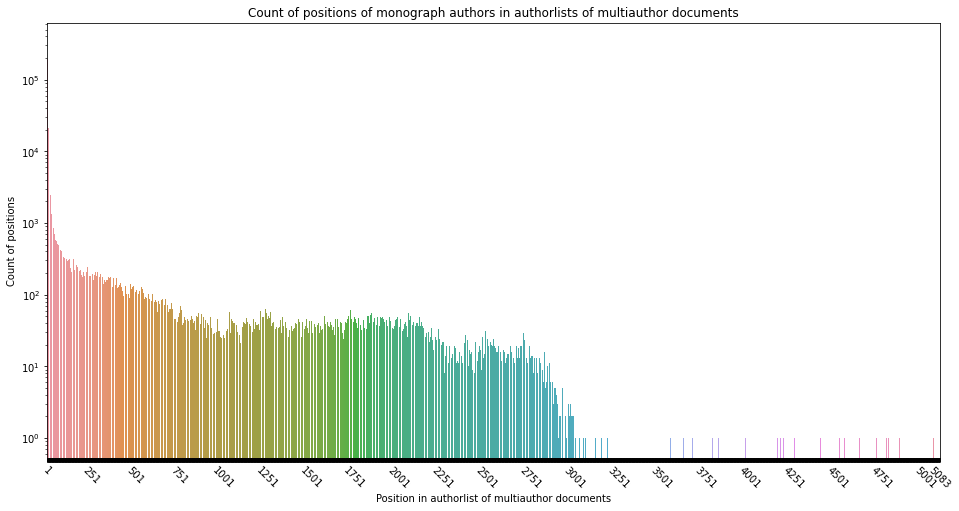

In [50]:
plt.figure(figsize=(16, 8))
plt.xticks(rotation=-45)
plot = sns.barplot(x=pos_freq.index, y=pos_freq)
plot.set(yscale='log',xlabel='Position in authorlist of multiauthor documents', ylabel='Count of positions',title='Count of positions of monograph authors in authorlists of multiauthor documents')
for i,label in enumerate(plot.xaxis.get_ticklabels()[:-1]):
    if i%250==0:
        continue
    else:
        label.set_visible(False)
plot

Next, we plot the number of monographies and multiauthor-documents over the corpus, and the number of documents which have monography- and multiauthors.

In [58]:
print(f'Number of monographs with matching multiauthor-documents: {df[df.multi_docs != 0].mono_docs.sum()}')

Number of monographs with matching multiauthor-documents: 261642


In [59]:
print(f'Number of monographies: {df.mono_docs.sum()}')
print(f'Number of documents without matching multiauthor-documents: {df[df.multi_docs == 0].mono_docs.sum()}')

Number of monographies: 973128
Number of documents without matching multiauthor-documents: 711486


In [ ]:
print(f"Documents with no matching monograph: {no_single}") #Calculated earlier

In [ ]:
print(f'Number of multiauthor-documents in total: {len(list(filter(lambda entry: len(entry) > 1, authors)))}')

In [78]:
print(f'Number of documents with no authors: {len(list(filter(lambda entry: len(entry) == 0, authors)))}')

7535

We put these numbers in a list (numbers for process_1 are taken from scripts in process_1/notebooks, but not used for the thesis anyways)

In [3]:
process_2 = [711486,261642,894974,1481108,7535]
process_1 = [759935,281774,713420,560395,0]
plotdata = pd.DataFrame({'Corpus':process_2,'First Extraction':process_1},index=['Mono_only','Mono_plus','Multi_plus','Multi_only','No_info'])
plotdata = plotdata.transpose()

Text(0, 0.5, 'Extraction run')

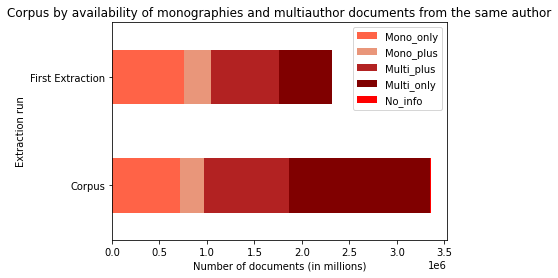

In [5]:
plotdata.plot(kind="barh",stacked=True,color=['tomato','darksalmon','firebrick','maroon','red'])
plt.title("Corpus by availability of monographies and multiauthor documents from the same author")
plt.xlabel("Number of documents (in millions)")
plt.ylabel("Extraction run")

In [4]:
sum(process_2)

3356745

In [6]:
plotdata = plotdata.loc[['Corpus']]

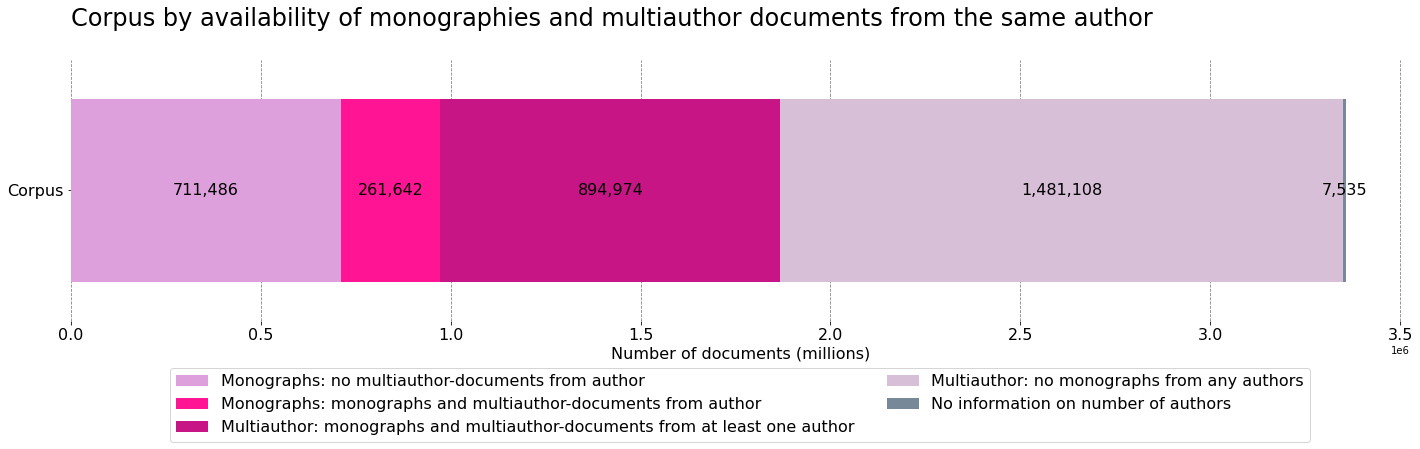

In [8]:
fields = ['Mono_only','Mono_plus','Multi_plus','Multi_only','No_info']
colors = ['plum','deeppink', 'mediumvioletred','thistle','lightslategray']
labels = ['Monographs: no multiauthor-documents from author','Monographs: monographs and multiauthor-documents from author','Multiauthor: monographs and multiauthor-documents from at least one author','Multiauthor: no monographs from any authors','No information on number of authors']

fig, ax = plt.subplots(1, figsize=(24, 6))

left = len(plotdata) * [0]
for idx, name in enumerate(fields):
    plt.barh(plotdata.index, plotdata[name], left = left, color=colors[idx], height=0.7)
    left = left + plotdata[name]
# title, legend, labels

for rect in ax.patches:
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    label_text = f'{width:,}'
    
    label_x = x + width / 2
    label_y = y + height / 2
    ax.text(label_x, label_y, label_text, ha='center', va='center',fontsize=16)

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2,
                 box.width, box.height * 0.8])
ax.legend(labels,loc='upper center', bbox_to_anchor=(0.5, -0.15),
          ncol=2,fontsize=16)
plt.title('Corpus by availability of monographies and multiauthor documents from the same author\n', loc='left',fontsize=24)
plt.xlabel('Number of documents (millions)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()

We calculate the most common combinations of monographies and multiauthor documents

In [10]:
df['comb'] = [(a,b) for a,b in zip(df['mono_docs'],df['multi_docs'])]
combo_frequencies = df['comb'][df['multi_docs'] > 0].value_counts()
combo_frequencies.nlargest(20)

(1, 1)     20631
(1, 2)     11222
(1, 3)      7711
(1, 4)      5740
(1, 5)      4372
(2, 1)      3989
(1, 6)      3599
(1, 7)      2865
(2, 2)      2491
(1, 8)      2427
(1, 9)      2078
(2, 3)      1863
(1, 10)     1817
(1, 11)     1524
(2, 4)      1420
(3, 1)      1400
(1, 12)     1329
(1, 13)     1210
(2, 5)      1165
(1, 14)     1049
Name: comb, dtype: int64

We add a column to our dataframe containing the total of documents per author

In [11]:
df['sum'] = [a+b for a,b in zip(df['mono_docs'],df['multi_docs'])]

In [12]:
df

,name,mono_docs,multi_docs,positions,avg_position,comb,sum
2648023147,Charlie Beckett,602,7,"[1, 1, 1, 2, 5, 1, 2]",1.9,"(602, 7)",609
217383518,Csusb,577,0,[],0.0,"(577, 0)",577
2561382056,Nigel Williams,391,0,[],0.0,"(391, 0)",391
2137451758,Steven Alan Samson,281,0,[],0.0,"(281, 0)",281
2098661866,Daily Egyptian Staff,246,0,[],0.0,"(246, 0)",246
...,...,...,...,...,...,...,...
2318434287,Afaf M. Abd El-Hameed,1,2,"[2, 3]",2.5,"(1, 2)",3
2155931765,C. A. Gagliardi,1,86,"[86, 92, 73, 88, 84, 72, 88, 309, 79, 99, 68, ...",87.2,"(1, 86)",87
2168795134,Andreas Heinemann,1,0,[],0.0,"(1, 0)",1
2327366664,Tanja Veikkola,1,0,[],0.0,"(1, 0)",1


In [63]:
len(df[df['sum'] > 5])

70073

In [64]:
len(df[df['sum'] > 10])

42065

In [65]:
len(df[df['mono_docs'] == 1])

731566

In [66]:
len(df[df['mono_docs'] > 5])

8601

In [67]:
len(df[df['mono_docs'] > 10])

2523

We take a closer look at the most frequent authors in the corpus and the positions in multiauthor documents they are listed in.

In [68]:
df.sort_values(by=['sum'],ascending=False).rename(columns={'name':'Name','mono_docs':'Monographies','multi_docs':"Multiauthor documents",'sum':'Documents combined','avg_position':'Average position in authorlists'}).head(10)[['Name','Monographies','Multiauthor documents','Documents combined','Average position in authorlists']]

,Name,Monographies,Multiauthor documents,Documents combined,Average position in authorlists
2322125285,Thomas E. Starzl,51,1041,1092,6.2
2114964236,Ray L. Frost,14,717,731,2.2
2779698592,B. Abbott,1,633,634,289.9
2648023147,Charlie Beckett,602,7,609,1.9
217383518,Csusb,577,0,577,0.0
2554158301,P. Baringer,1,570,571,769.5
2585383040,P. C. Bhat,2,568,570,841.7
2161346604,S. Banerjee,1,568,569,449.2
2605036012,S. Malik,1,567,568,691.9
2529492022,N. Varelas,1,563,564,1086.4


In [69]:
tops = df.sort_values(by=['sum'],ascending=False).head(10)
def analyze(id):
    line = tops.loc[id]
    if line.positions == []:
        line.positions = [0]
    n = line['name']
    return f'For {n}: Position lower than 5 in {len([p for p in line.positions if p < 5 ])}, lowest position {min(line.positions)}'

for i in tops.index:
    print(analyze(i))

For Thomas E. Starzl: Position lower than 5 in 340, lowest position 1
For Ray L. Frost: Position lower than 5 in 615, lowest position 1
For B. Abbott: Position lower than 5 in 535, lowest position 1
For Charlie Beckett: Position lower than 5 in 6, lowest position 1
For Csusb: Position lower than 5 in 1, lowest position 0
For P. Baringer: Position lower than 5 in 4, lowest position 1
For P. C. Bhat: Position lower than 5 in 4, lowest position 1
For S. Banerjee: Position lower than 5 in 10, lowest position 1
For S. Malik: Position lower than 5 in 4, lowest position 1
For N. Varelas: Position lower than 5 in 1, lowest position 3


/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [70]:
tops.loc[2322125285]['name']

'Thomas E. Starzl'

In [71]:
print(f"Total frequency mean: {df['sum'].mean()}")
print(f"Total frequency median: {df['sum'].median()}")

Total frequency mean: 3.03543829894155
Total frequency median: 1.0


We calculate the number of multiauthor documents for which for all authors a monography is available.

In [72]:
all_known = list(filter(lambda entry: all([x['id'] in author_idset for x in entry]),authors))

In [73]:
all_known_multi = list(filter(lambda entry: len(entry) > 1, all_known))
len(all_known_multi)

66706

In [74]:
len_all_known_multi = list(map(lambda entry: len(entry),all_known_multi))
pd.Series(len_all_known_multi).value_counts()

2    54149
3    10635
4     1678
5      210
6       26
7        8
dtype: int64

Then, we calculate the share of known (=monography available) authors for all documents

In [75]:
def share(entry):
    return (sum([i['id'] in author_idset for i in entry]),len(entry))

known_v_all = list(map(lambda entry: share(entry),authors))
shares = pd.DataFrame(known_v_all)
shares = shares.rename(columns={0:"known",1:"total"})

In [76]:
shares

,known,total
0,0,2
1,0,2
2,1,3
3,1,1
4,0,2
...,...,...
3356740,1,1
3356741,1,1
3356742,0,3
3356743,1,1


In [77]:
l = [a/b >= 0.5 if b != 0 else False for a,b in zip(shares['known'],shares['total']) ]
print(f'Dcouments with at least 50% known authors: {sum(l)}')

Dcouments with at least 50% known authors: 1327805


For documents with upto 10 authors, we create a heatmap with the number of authors in total and the number of authors which also have a monography

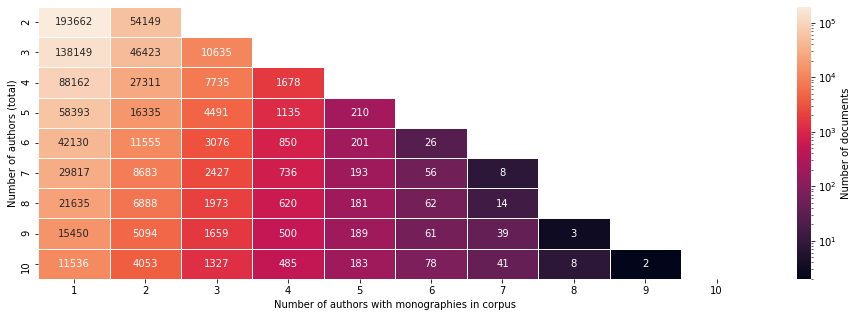

In [ ]:
ind= range(11)[2:]
col = range(11)[1:]
hmdf = pd.DataFrame([[len(shares[(shares['total']==j) & (shares['known']==i)]) for i in col] for j in ind], index=ind, columns=col).astype(float)
mask = np.ma.masked_where(hmdf == 0.0, hmdf)

plt.figure(figsize = (16,5))
sns.heatmap(hmdf, linewidth=0.5, annot=True, mask=mask.mask, fmt='.0f',norm=LogNorm(),cbar_kws={'label': 'Number of documents'})
plt.ylabel("Number of authors (total)")
plt.xlabel("Number of authors with monographies in corpus")
plt.show()

Then, we create a heatmap with the combination of monographies and multiauthor documents per author

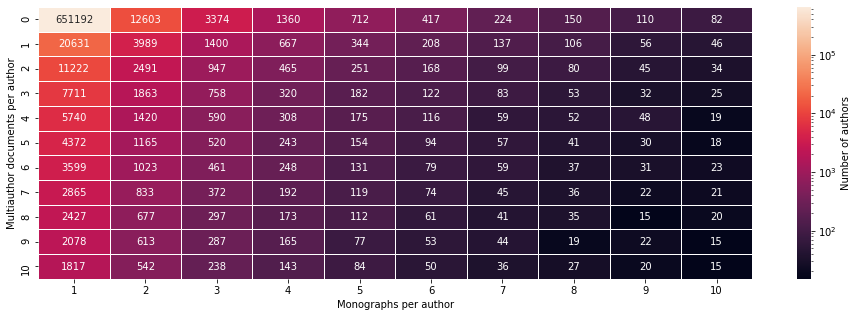

In [80]:


ind= range(11)[1:]
col = range(11)[0:]
hmdf = pd.DataFrame([[len(df[(df['mono_docs']==i) & (df['multi_docs']==j)]) for i in ind] for j in col], index=col, columns=ind)

plt.figure(figsize = (16,5))
sns.heatmap(hmdf, linewidth=0.5, annot=True, fmt='d',norm=LogNorm(),cbar_kws={'label': 'Number of authors'})
plt.xlabel("Monographs per author")
plt.ylabel("Multiauthor documents per author")
plt.show()

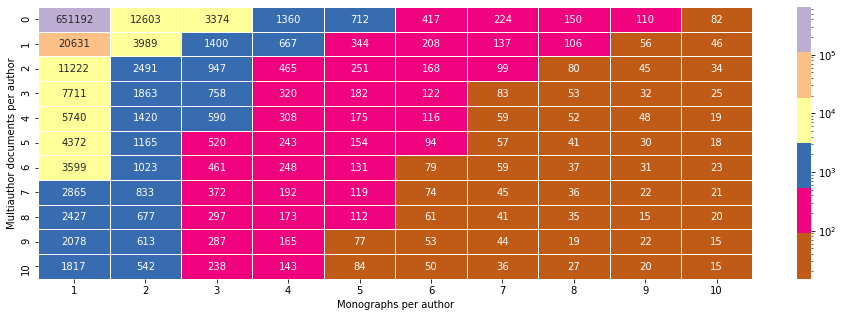

In [81]:
ind= range(11)[1:]
col = range(11)[0:]
hmdf = pd.DataFrame([[len(df[(df['mono_docs']==i) & (df['multi_docs']==j)]) for i in ind] for j in col], index=col, columns=ind)

plt.figure(figsize = (16,5))
sns.heatmap(hmdf, linewidth=0.5, annot=True, fmt='d',norm=LogNorm(),cmap=sns.color_palette("Accent_r"))
plt.xlabel("Monographs per author")
plt.ylabel("Multiauthor documents per author")
plt.show()

Next, we create countplot showing the counts of available monographies per author. We create different versions with grouped and ungrouped bars for high numbers

In [84]:
mono_freq = df['mono_docs'].value_counts()
ser = pd.Series(data=[0 for i in range(max(mono_freq.index)+1)[1:]], index=range(max(mono_freq.index)+1)[1:])
mono_freq = mono_freq.combine(ser, max, fill_value=0).sort_index()

In [85]:
mono_freq

1      731566
2       33624
3       12453
4        6189
5        3542
        ...  
598         0
599         0
600         0
601         0
602         1
Length: 602, dtype: int64

In [27]:
mono_freq = df['mono_docs'].value_counts()
ser = pd.Series(data=[0 for i in range(102)[1:]], index=range(102)[1:])
mono_freq = mono_freq.combine(ser, max, fill_value=0).sort_index()
app = pd.Series(data=[sum(mono_freq[mono_freq.index > 100])], index=['>100'])
mono_freq = mono_freq[mono_freq.index <= 100].append(app)

<AxesSubplot:title={'center':'Authorcount by number of available monographs (authors with more than 100 monographs grouped)'}, xlabel='Number of monographs per author', ylabel='Count of authors'>

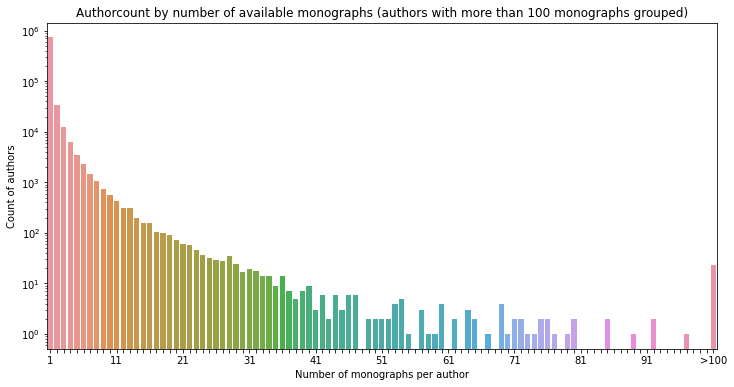

In [28]:
plt.figure(figsize=(12, 6))
plot = sns.barplot(x=mono_freq.index, y=mono_freq)
plot.set(yscale='log',xlabel='Number of monographs per author', ylabel='Count of authors',title='Authorcount by number of available monographs (authors with more than 100 monographs grouped)')
for i,label in enumerate(plot.xaxis.get_ticklabels()):
    if i < 100:
        if i%10==0:
            continue
        else:
            label.set_visible(False)
    else:
        if i%100==0:
            continue
        else:
            label.set_visible(False)
plot

In [46]:
mono_freq = df['mono_docs'].value_counts()
ser = pd.Series(data=[0 for i in range(max(mono_freq.index)+1)[1:]], index=range(max(mono_freq.index)+1)[1:])
mono_freq = mono_freq.combine(ser, max, fill_value=0).sort_index()

<AxesSubplot:title={'center':'Authorcount by number of available monographs'}, xlabel='Number of monographs per author', ylabel='Count of authors'>

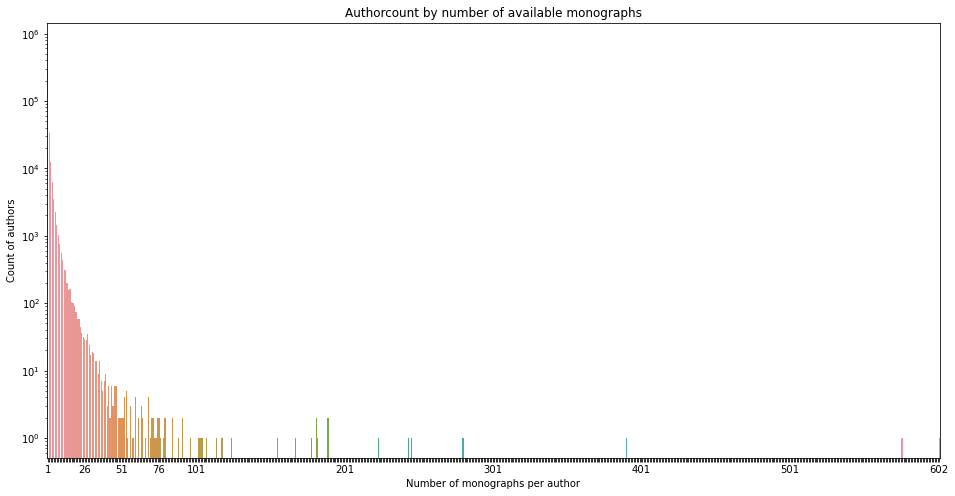

In [47]:
plt.figure(figsize=(16, 8))
plot = sns.barplot(x=mono_freq.index, y=mono_freq)
plot.set(yscale='log',xlabel='Number of monographs per author', ylabel='Count of authors',title='Authorcount by number of available monographs')
for i,label in enumerate(plot.xaxis.get_ticklabels()[:-1]):
    if i < 100:
        if i%25==0:
            continue
        else:
            label.set_visible(False)
    else:
        if i%100==0 and i != 600:
            continue
        else:
            label.set_visible(False)
plot

We do the same again for the total number of documents

In [88]:
comb_freq = df['sum'].value_counts()
ser = pd.Series(data=[0 for i in range(102)[1:]], index=range(102)[1:])
comb_freq = comb_freq.combine(ser, max, fill_value=0).sort_index()
app = pd.Series(data=[sum(comb_freq[comb_freq.index > 100])], index=['>100'])
comb_freq = comb_freq[comb_freq.index <= 100].append(app)

<AxesSubplot:title={'center':'Authorcount by number of available documents (monographies + multiauthor documents). Authors with more than 100 documents grouped, only authors with at least 1 monography counted'}, xlabel='Number of documents per author', ylabel='Count of authors'>

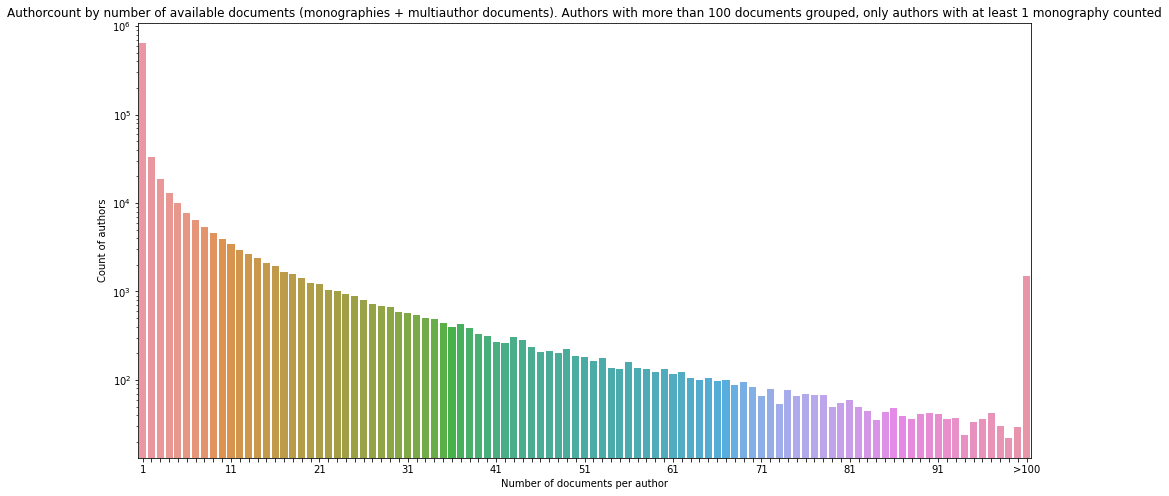

In [138]:
plt.figure(figsize=(16, 8))
plot = sns.barplot(x=comb_freq.index, y=comb_freq)
plot.set(yscale='log',xlabel='Number of documents per author', ylabel='Count of authors',title='Authorcount by number of available documents (monographies + multiauthor documents). Authors with more than 100 documents grouped, only authors with at least 1 monography counted')
for i,label in enumerate(plot.xaxis.get_ticklabels()):
    if i <= 100:
        if i%10==0:
            continue
        else:
            label.set_visible(False)
    else:
        continue
plot

In [33]:
comb_freq = df['sum'].value_counts()
ser = pd.Series(data=[0 for i in range(max(comb_freq.index)+1)[1:]], index=range(max(comb_freq.index)+1)[1:])
comb_freq = comb_freq.combine(ser, max, fill_value=0).sort_index()

<AxesSubplot:title={'center':'Authorcount by number of available documents (monographies + multiauthor documents). Only authors with at least 1 monography counted'}, xlabel='Number of documents per author', ylabel='Count of authors'>

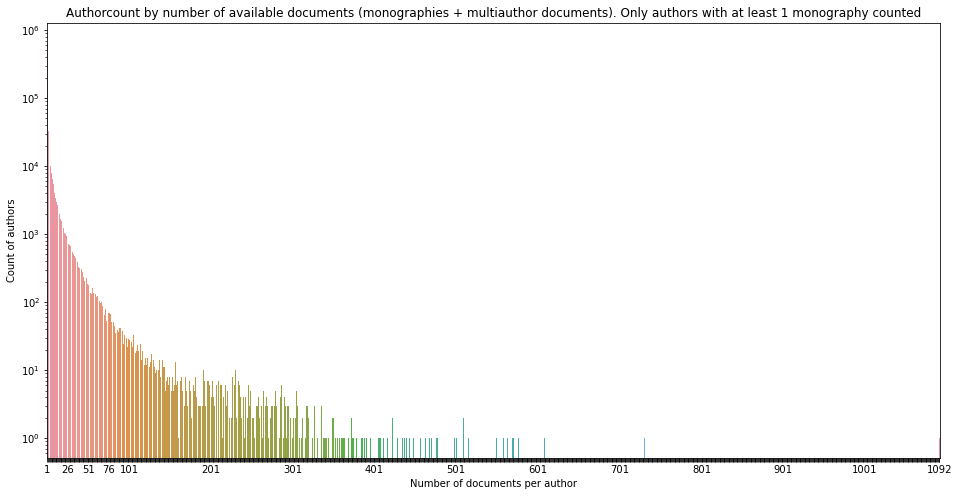

In [45]:
plt.figure(figsize=(16, 8))
plot = sns.barplot(x=comb_freq.index, y=comb_freq)
plot.set(yscale='log',xlabel='Number of documents per author', ylabel='Count of authors',title='Authorcount by number of available documents (monographies + multiauthor documents). Only authors with at least 1 monography counted')
for i,label in enumerate(plot.xaxis.get_ticklabels()[:-1]):
    if i <= 100:
        if i%25==0:
            continue
        else:
            label.set_visible(False)
    else:
        if i%100==0:
            continue
        else:
            label.set_visible(False)
plot

<AxesSubplot:title={'center':'Authorcount by number of available monographies (bars with height 0 left out)'}, xlabel='Number of monographies per author', ylabel='Count of authors'>

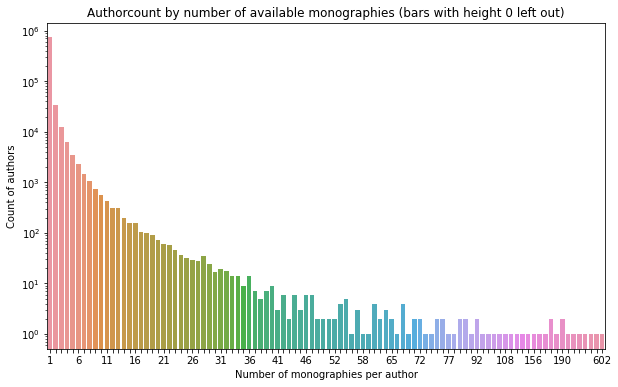

In [90]:
plt.figure(figsize=(10, 6))
plot = sns.countplot(data=df,x='mono_docs')
plot.set(yscale='log',xlabel='Number of monographies per author', ylabel='Count of authors',title='Authorcount by number of available monographies (bars with height 0 left out)')
l = len(plot.xaxis.get_ticklabels())
for i,label in enumerate(plot.xaxis.get_ticklabels()[:-1]):
    if i%5==0 and i<l-5:
        continue
    else:
        label.set_visible(False)
plot

<AxesSubplot:title={'center':'Authorcount by number of available monographs (bars with height 0 left out)'}, xlabel='Number of monographs per author', ylabel='Number of authors'>

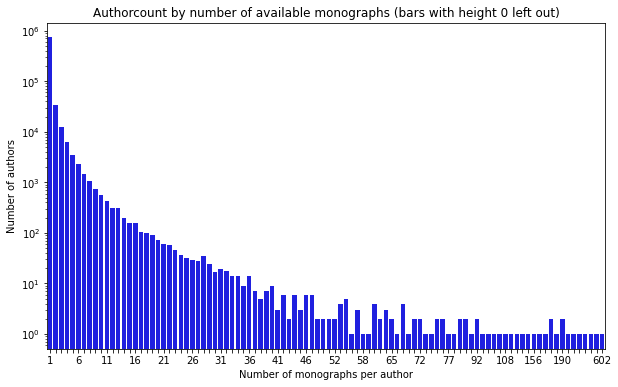

In [91]:
plt.figure(figsize=(10, 6))
plot = sns.countplot(data=df,x='mono_docs',color='blue')
plot.set(yscale='log',xlabel='Number of monographs per author', ylabel='Number of authors',title='Authorcount by number of available monographs (bars with height 0 left out)')
l = len(plot.xaxis.get_ticklabels())
for i,label in enumerate(plot.xaxis.get_ticklabels()[:-1]):
    if i%5==0 and i<l-5:
        continue
    else:
        label.set_visible(False)
plot

<AxesSubplot:title={'center':'Authorcount by number of available documents, only authors with at least one monography considered (bars with height 0 left out)'}, xlabel='Number of documents per author', ylabel='Count of authors'>

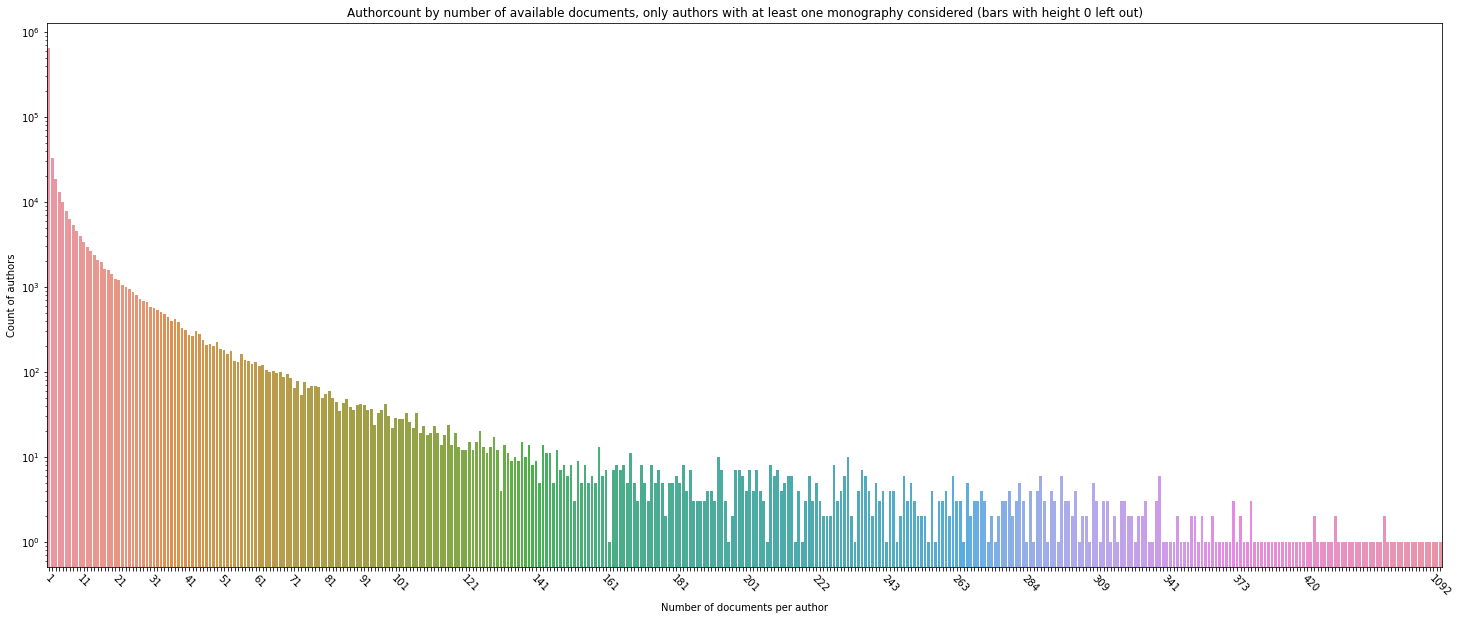

In [92]:
plt.figure(figsize=(25, 10))
plt.xticks(rotation=-45)
plot = sns.countplot(data=df,x='sum')
plot.set(yscale='log',xlabel='Number of documents per author', ylabel='Count of authors',title='Authorcount by number of available documents, only authors with at least one monography considered (bars with height 0 left out)')
l = len(plot.xaxis.get_ticklabels())
for i,label in enumerate(plot.xaxis.get_ticklabels()[:-1]):
    if i%10==0 and i<100:
        continue
    elif i%20==0 and i>=100 and i<l-20:
        continue
    else:
        label.set_visible(False)
plot

<AxesSubplot:title={'center':'Authorcount by number of available documents, only authors with at least one monography considered (bars with height 0 left out)'}, xlabel='Number of documents per author', ylabel='Count of authors'>

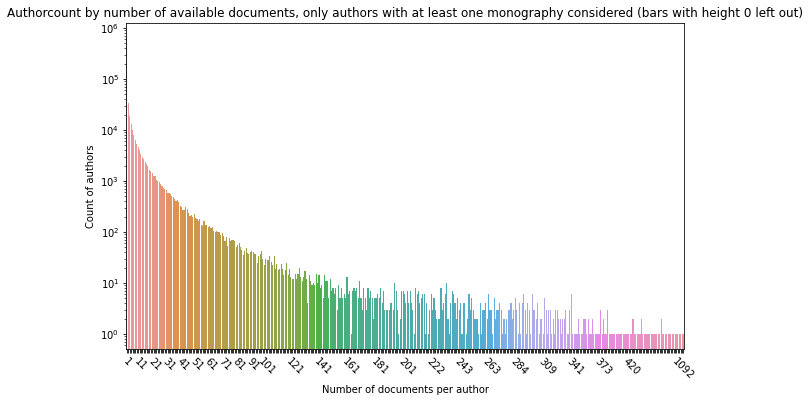

In [93]:
plt.figure(figsize=(10, 6))
plt.xticks(rotation=-45)
plot = sns.countplot(data=df,x='sum')
plot.set(yscale='log',xlabel='Number of documents per author', ylabel='Count of authors',title='Authorcount by number of available documents, only authors with at least one monography considered (bars with height 0 left out)')
l = len(plot.xaxis.get_ticklabels())
for i,label in enumerate(plot.xaxis.get_ticklabels()[:-1]):
    if i%10==0 and i<100:
        continue
    elif i%20==0 and i>=100 and i<l-20:
        continue
    else:
        label.set_visible(False)
plot

In [94]:
df['sum'].value_counts().sort_index().head(20)

1     651192
2      33234
3      18585
4      12962
5       9929
6       7776
7       6357
8       5353
9       4576
10      3946
11      3410
12      2953
13      2638
14      2375
15      2096
16      1941
17      1649
18      1570
19      1423
20      1253
Name: sum, dtype: int64

In [95]:
df['mono_docs'].value_counts().sort_index().head(20)

1     731566
2      33624
3      12453
4       6189
5       3542
6       2271
7       1463
8       1037
9        746
10       561
11       434
12       306
13       306
14       201
15       156
16       160
17       103
18       100
19        90
20        73
Name: mono_docs, dtype: int64

Next, we take a look at the length of the documents and extract the data for this from the corpus files

In [96]:
def length(line):
    j = loads(line)
    return(len(j['fullText']),len(j['fullText'].split()),len(j['authors']))

print(datetime.now())
lengths = []
for p in filepaths:
    print(basename(p))
    rdd = sc.textFile(f"file://{p}")
    data = rdd.map(lambda line: length(line))
    lengths = lengths + data.collect()
    print(datetime.now())
textlength = pd.DataFrame(lengths,columns=["characters","words","authors"])

2021-06-24 19:43:12.296667
00
2021-06-24 19:45:03.878136
01
2021-06-24 19:47:30.242410
02
2021-06-24 19:49:09.799101
03
2021-06-24 19:52:33.866831
04
2021-06-24 19:54:05.408282
05
2021-06-24 19:55:44.326465
06
2021-06-24 19:56:43.733334
08
2021-06-24 19:57:12.729803
09
2021-06-24 19:57:41.504818
10
2021-06-24 19:58:09.524947
11
2021-06-24 19:58:37.445397
12
2021-06-24 19:59:06.343981
13
2021-06-24 19:59:35.196367
14
2021-06-24 20:01:08.437380
15
2021-06-24 20:03:05.709788
16
2021-06-24 20:05:05.660844
17
2021-06-24 20:06:58.340178
18
2021-06-24 20:08:55.251598
19
2021-06-24 20:10:10.898750
20
2021-06-24 20:11:45.936362
21
2021-06-24 20:13:59.555741
22
2021-06-24 20:16:00.448595
23
2021-06-24 20:16:46.517398
24
2021-06-24 20:17:32.984956
25
2021-06-24 20:18:26.249818
26
2021-06-24 20:19:20.925381
27
2021-06-24 20:20:16.410544
28
2021-06-24 20:21:11.204092
29
2021-06-24 20:22:38.009721
30
2021-06-24 20:25:08.468669
31
2021-06-24 20:26:31.089732
32
2021-06-24 20:28:27.323111
33
2021-06-24

We define a method that returns the number of documents fallin in specified windows of textlength

In [97]:
def total_for_classes(label,series,classes):
    print(label)
    for lower,upper in classes:
        if not upper:
            upper = float('inf')
        print(f'From {lower} to {upper}: {len(series[(series >= lower) & (series <= upper)])}')
    print('\n\n')

Then we use this method, on the number of characters and the number of words

In [98]:
total_for_classes('Length by characters',textlength['characters'],[(0,3000),(3001,5000),(5001,50000),(50001,250000),(250001,None)])
total_for_classes('Length by words',textlength['words'],[(0,500),(501,1000),(1001,10000),(10001,40000),(40001,None)])
total_for_classes('Length by characters for monographies',textlength[textlength['authors'] == 1]['characters'],[(0,3000),(3001,5000),(5001,50000),(50001,250000),(250001,None)])
total_for_classes('Length by characters for multiauthor',textlength[textlength['authors'] > 1]['characters'],[(0,3000),(3001,5000),(5001,50000),(50001,250000),(250001,None)])



Length by characters
From 0 to 3000: 39354
From 3001 to 5000: 96069
From 5001 to 50000: 2273249
From 50001 to 250000: 771756
From 250001 to inf: 176317



Length by words
From 0 to 500: 57650
From 501 to 1000: 148305
From 1001 to 10000: 2463795
From 10001 to 40000: 513298
From 40001 to inf: 173697



Length by characters for monographies
From 0 to 3000: 13704
From 3001 to 5000: 32060
From 5001 to 50000: 467847
From 50001 to 250000: 301975
From 250001 to inf: 157542



Length by characters for multiauthor
From 0 to 3000: 25597
From 3001 to 5000: 63833
From 5001 to 50000: 1799435
From 50001 to 250000: 468473
From 250001 to inf: 18744





In [99]:
print("Text_char_mean: ",textlength['characters'].mean())
print("Text_char_median: ",textlength['characters'].median())
print("Text_words_mean: ",textlength['words'].mean())
print("Text_words_median: ",textlength['words'].median())
print("Text_char_mono__mean: ",textlength[textlength['authors'] == 1]['characters'].mean())
print("Text_char_mono_median: ",textlength[textlength['authors'] == 1]['characters'].median())
print("Text_char_multi_mean: ",textlength[textlength['authors'] > 1]['characters'].mean())
print("Text_char_multi_median: ",textlength[textlength['authors'] > 1]['characters'].median())

Text_char_mean:  62853.0570281627
Text_char_median:  31234.0
Text_words_mean:  10026.509679764176
Text_words_median:  5008.0
Text_char_mono__mean:  122083.44053094763
Text_char_mono_median:  44862.0
Text_char_multi_mean:  38685.91932433308
Text_char_multi_median:  29071.0


In [100]:
print("Shorter than 3000: ",len(textlength[textlength['characters'] <= 3000]))
print("3001-5000: ",len(textlength[(textlength['characters'] > 3000) & (textlength['characters'] <= 5000)]))
print("5001-50000: ",len(textlength[(textlength['characters'] > 5000) & (textlength['characters'] <= 50000)]))
print("50001-250000: ",len(textlength[(textlength['characters'] > 50000) & (textlength['characters'] <= 250000)]))
print("Longer than 250000: ",len(textlength[textlength['characters'] > 250000]))

Shorter than 3000:  39354
3001-5000:  96069
5001-50000:  2273249
50001-250000:  771756
Longer than 250000:  176317


In [101]:
print("Shorter than 500: ",len(textlength[textlength['words'] <= 500]))
print("500-1000: ",len(textlength[(textlength['words'] > 500) & (textlength['words'] <= 1000)]))
print("1001-10000: ",len(textlength[(textlength['words'] > 1000) & (textlength['words'] <= 10000)]))
print("10001-40000: ",len(textlength[(textlength['words'] > 10000) & (textlength['words'] <= 40000)]))
print("Longer than 40000: ",len(textlength[textlength['words'] > 40000]))

Shorter than 500:  57650
500-1000:  148305
1001-10000:  2463795
10001-40000:  513298
Longer than 40000:  173697


In [102]:
print("Shorter than 1000: ",len(textlength[textlength['characters'] < 1000]))
print("Shorter than 100: ",len(textlength[textlength['characters'] < 500]))
print("Shorter than 100 words: ",len(textlength[textlength['words'] < 100]))
print("Shorter than 5 words: ",len(textlength[textlength['words'] < 5]))

Shorter than 1000:  0
Shorter than 100:  0
Shorter than 100 words:  2
Shorter than 5 words:  0


Last, we look at the statistics for seperate fields of study. We extract the FOS data from the corpus files

In [103]:
def get_fields_stats(line):
    j = loads(line)
    return (j['fieldsOfStudy'],len(j['authors']),len(j['fullText']))

print(datetime.now())
all_data = []
for p in filepaths:
    print(basename(p))
    rdd = sc.textFile(f"file://{p}")
    data = rdd.map(lambda line: get_fields_stats(line))
    all_data = all_data + data.collect()
    print(datetime.now())

2021-06-24 20:32:23.471856
00
2021-06-24 20:33:20.597284
01
2021-06-24 20:34:34.689319
02
2021-06-24 20:35:30.776075
03
2021-06-24 20:37:12.458276
04
2021-06-24 20:38:09.760062
05
2021-06-24 20:39:02.266034
06
2021-06-24 20:39:20.383090
07
2021-06-24 20:39:37.024711
08
2021-06-24 20:39:53.605993
09
2021-06-24 20:40:10.397130
10
2021-06-24 20:40:27.298581
11
2021-06-24 20:40:44.185341
12
2021-06-24 20:41:00.974309
13
2021-06-24 20:41:18.371699
14
2021-06-24 20:42:15.486468
15
2021-06-24 20:43:18.217718
16
2021-06-24 20:44:18.913649
17
2021-06-24 20:45:26.918201
18
2021-06-24 20:46:30.348457
19
2021-06-24 20:47:14.416126
20
2021-06-24 20:48:09.976351
21
2021-06-24 20:49:23.358685
22
2021-06-24 20:50:31.059544
23
2021-06-24 20:50:59.701844
24
2021-06-24 20:51:26.912087
25
2021-06-24 20:51:58.109023
26
2021-06-24 20:52:38.810494
27
2021-06-24 20:53:12.945759
28
2021-06-24 20:53:46.378552
29
2021-06-24 20:54:35.417281
30
2021-06-24 20:55:55.210311
31
2021-06-24 20:56:43.218392
32
2021-06-24

In [104]:
fosstats = pd.DataFrame(all_data,columns=['field','num_of_authors','textlength'])
fosstats = fosstats.explode('field')
groups = fosstats.groupby(['field'])
groups['num_of_authors'].median()

field
Agriculture, Forestry and Veterinary Medicine                                                    4
Analytical Chemistry, Method Development (Chemistry)                                             4
Ancient Cultures                                                                                 3
Astrophysics and Astronomy                                                                       3
Atmospheric Science, Oceanography and Climate Research                                           4
Basic Biological and Medical Research                                                            5
Biological Chemistry and Food Chemistry                                                          4
Computer Science                                                                                 3
Condensed Matter Physics                                                                         3
Construction Engineering and Architecture                                                        3
Econ

In [105]:
groups['textlength'].median()

field
Agriculture, Forestry and Veterinary Medicine                                                    37895.0
Analytical Chemistry, Method Development (Chemistry)                                             27034.0
Ancient Cultures                                                                                 42384.5
Astrophysics and Astronomy                                                                       31597.0
Atmospheric Science, Oceanography and Climate Research                                           43997.0
Basic Biological and Medical Research                                                            33658.0
Biological Chemistry and Food Chemistry                                                          35167.0
Computer Science                                                                                 32190.0
Condensed Matter Physics                                                                         24734.0
Construction Engineering and Architecture        

In [106]:
fosstats['field'].dropna().value_counts()

Basic Biological and Medical Research                                                            560611
Condensed Matter Physics                                                                         356246
Mathematics                                                                                      289774
Particles, Nuclei and Fields                                                                     274894
Microbiology, Virology and Immunology                                                            258438
Computer Science                                                                                 202645
Medicine                                                                                         147460
Molecular Chemistry                                                                              140295
Economics                                                                                        125583
Psychology                                                      

In [108]:
groups['num_of_authors'].apply(lambda ser: (len(ser[ser == 1]),len(ser[ser > 1])))

field
Agriculture, Forestry and Veterinary Medicine                                                      (6152, 85084)
Analytical Chemistry, Method Development (Chemistry)                                               (3501, 66382)
Ancient Cultures                                                                                    (1281, 2757)
Astrophysics and Astronomy                                                                         (5233, 28491)
Atmospheric Science, Oceanography and Climate Research                                             (2095, 37401)
Basic Biological and Medical Research                                                            (35502, 523122)
Biological Chemistry and Food Chemistry                                                              (577, 9915)
Computer Science                                                                                 (28319, 173533)
Condensed Matter Physics                                                                  

In [143]:
d = pd.DataFrame(groups['num_of_authors'].apply(lambda ser: (len(ser[ser == 1]),len(ser[ser > 1]))))
d['Monographies'] = [t[0] for t in d['num_of_authors']]
d['Multiauthor documents'] = [t[1] for t in d['num_of_authors']]
d.drop(columns=['num_of_authors']).sort_values(by=['Monographies'],ascending=False)

,Monographies,Multiauthor documents
field,,
Mathematics,88603,199988
Condensed Matter Physics,52175,302796
"Particles, Nuclei and Fields",48681,225187
Basic Biological and Medical Research,35502,523122
Economics,32378,92697
Computer Science,28319,173533
Social Sciences,20195,26244
Psychology,17400,99575
Mechanics and Constructive Mechanical Engineering,15432,66116


We map all fields to their research area and calculate the same measures again

In [144]:
d = pd.DataFrame(groups['num_of_authors'].apply(lambda ser: (round(len(ser[ser == 1])/len(ser),3),round(len(ser[ser > 1])/len(ser),3))))
d['Share of monographies'] = [t[0] for t in d['num_of_authors']]
d['Share of multiauthor documents'] = [t[1] for t in d['num_of_authors']]
d.drop(columns=['num_of_authors']).sort_values(by=['Share of monographies'],ascending=False)

,Share of monographies,Share of multiauthor documents
field,,
Theology,0.841,0.154
Philosophy,0.678,0.316
History,0.636,0.356
"Social and Cultural Anthropology, Non-European Cultures, Jewish Studies and Religious Studies",0.560,0.435
"Fine Arts, Music, Theatre and Media Studies",0.549,0.445
Jurisprudence,0.503,0.492
Social Sciences,0.433,0.562
Ancient Cultures,0.316,0.679
Linguistics,0.313,0.683


In [107]:
def map_area(f):
    areas = []
    if any([fs in ['Ancient Cultures','Economics','Educational Research','Fine Arts, Music, Theatre and Media Studies',
            'History','Jurisprudence','Linguistics','Philosophy','Psychology','Social Sciences',
            'Social and Cultural Anthropology, Non-European Cultures, Jewish Studies and Religious Studies',
            'Theology'] for fs in f]) and not 'Humanities and Social Sciences' in areas:
        areas.append('Humanities and Social Sciences')
    if any([fs in ['Agriculture, Forestry and Veterinary Medicine','Basic Biological and Medical Research','Medicine',
               'Microbiology, Virology and Immunology','Neurosciences','Plant Sciences','Zoology'
              ] for fs in f]) and not 'Life Sciences' in areas:
        areas.append('Life Sciences')
    if any([fs in ['Analytical Chemistry, Method Development (Chemistry)','Astrophysics and Astronomy',
               'Atmospheric Science, Oceanography and Climate Research','Biological Chemistry and Food Chemistry',
              'Condensed Matter Physics','Geochemistry, Mineralogy and Crystallography','Geography',
              'Geology and Palaeontology','Geophysics and Geodesy','Mathematics','Molecular Chemistry','Optics, Quantum Optics and Physics of Atoms, Molecules and Plasmas',
              'Particles, Nuclei and Fields','Physical and Theoretical Chemistry','Polymer Research','Statistical Physics, Soft Matter, Biological Physics, Nonlinear Dynamics',
              'Water Research'] for fs in f]) and not 'Natural Sciences' in areas:
        areas.append('Natural Sciences')
    if any([fs in ['Computer Science','Construction Engineering and Architecture',
               'Electrical Engineering and Information Technology','Heat Energy Technology, Thermal Machines, Fluid Mechanics',
               'Materials Engineering','Materials Science','Mechanics and Constructive Mechanical Engineering',
              'Process Engineering, Technical Chemistry','Production Technology','Systems Engineering'] for fs in f])  and not 'Engineering Sciences' in areas:
        areas.append('Engineering Sciences')
    return areas

In [133]:
areas = pd.DataFrame(all_data,columns=['field','num_of_authors','textlength'])
areas['area'] = [map_area(f) for f in areas['field']]
areas = areas.explode('area')
areas = areas.groupby(['area'])
areas['num_of_authors'].apply(lambda ser: (round(len(ser[ser == 1])/len(ser),3),round(len(ser[ser > 1])/len(ser),3)))

area
Engineering Sciences              (0.127, 0.869)
Humanities and Social Sciences    (0.225, 0.771)
Life Sciences                     (0.064, 0.933)
Natural Sciences                  (0.184, 0.813)
Name: num_of_authors, dtype: object

In [111]:
areas['num_of_authors'].apply(lambda ser: (len(ser[ser == 1]),len(ser[ser > 1])))

area
Engineering Sciences               (55016, 375205)
Humanities and Social Sciences     (58318, 199926)
Life Sciences                      (48726, 715219)
Natural Sciences                  (147025, 651077)
Name: num_of_authors, dtype: object

In [112]:
areas['num_of_authors'].median()

area
Engineering Sciences              3
Humanities and Social Sciences    3
Life Sciences                     5
Natural Sciences                  3
Name: num_of_authors, dtype: int64

In [113]:
areas['textlength'].median()

area
Engineering Sciences              28467
Humanities and Social Sciences    37224
Life Sciences                     32616
Natural Sciences                  26103
Name: textlength, dtype: int64

In [ ]:
x = pd.DataFrame(all_data,columns=['field','num_of_authors','textlength'])['field']
x[[len(a) != 0 for a in x]]

24                  [Social Sciences, Economics, Psychology]
37         [Materials Science, Particles, Nuclei and Fields]
38         [Particles, Nuclei and Fields, Molecular Chemi...
39         [Particles, Nuclei and Fields, Condensed Matte...
40         [Condensed Matter Physics, Heat Energy Technol...
                                 ...                        
3356232    [Basic Biological and Medical Research, Plant ...
3356237    [Basic Biological and Medical Research, Microb...
3356241    [Basic Biological and Medical Research, Molecu...
3356707          [Construction Engineering and Architecture]
3356739                   [Educational Research, Psychology]
Name: field, Length: 1702872, dtype: object

In [ ]:
len(groups)

46

In [ ]:
areas = pd.DataFrame(all_data,columns=['field','num_of_authors','textlength'])
areas['area'] = [map_area(f) for f in areas['field']]

In [ ]:
areas = areas.explode('area').dropna()
areas

,field,num_of_authors,textlength,area
24,"[Social Sciences, Economics, Psychology]",5,35339,Humanities and Social Sciences
37,"[Materials Science, Particles, Nuclei and Fields]",3,16240,Natural Sciences
37,"[Materials Science, Particles, Nuclei and Fields]",3,16240,Engineering Sciences
38,"[Particles, Nuclei and Fields, Molecular Chemi...",5,54178,Natural Sciences
39,"[Particles, Nuclei and Fields, Condensed Matte...",15,18617,Natural Sciences
...,...,...,...,...
3356237,"[Basic Biological and Medical Research, Microb...",6,48327,Life Sciences
3356241,"[Basic Biological and Medical Research, Molecu...",9,18337,Life Sciences
3356241,"[Basic Biological and Medical Research, Molecu...",9,18337,Natural Sciences
3356707,[Construction Engineering and Architecture],6,26427,Engineering Sciences


<AxesSubplot:title={'center':'Number of documents by DFG research area'}, xlabel='Research area', ylabel='Number of documents'>

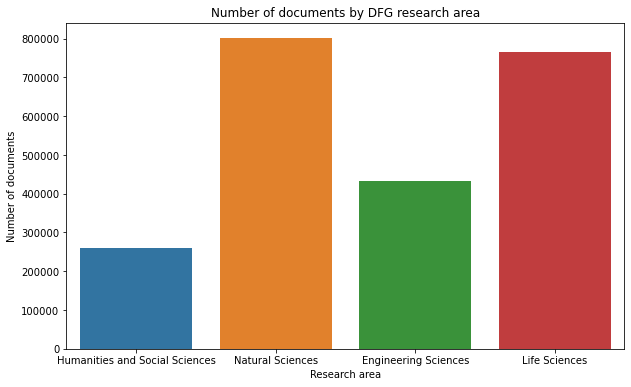

In [ ]:
plt.figure(figsize=(10, 6))
plot = sns.countplot(data=areas,x='area')
plot.set(ylabel='Number of documents',xlabel='Research area',title='Number of documents by DFG research area')
plot